# Housing Data for the country of US has been collected from various public sources.
# All datapoints are from the 2002 January to 2020 November timeframe, frequency being monthly Number of datapoints for each feature being **227**

#The code is divided into two parts: EDA and Regression Analysis, and Time-Series Analysis





In [236]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from sklearn.linear_model import LinearRegression

#Function to merge all 19 dataset

In [4]:
def files(path):
    for file in os.listdir(path):
        if os.path.isfile(os.path.join(path, file)):
            yield file
def wex_input_folder(folder):
    filelist = []
    works = []
    for file in files(folder):
        filelist.append(folder+'/'+file)
    return filelist

#Function to clean the dataset and making minor changes to obtain desired dataset to work on

In [6]:
l=[]
c= wex_input_folder("/content/Housing ML")
for i in c:
    l.append(pd.read_csv(i))
for o in l:
    o.drop(['DATE'] , axis=1 , inplace=True)
df =  l[0]
u=1
while u<len(l):
    df2 = df.join(l[u])
    df=df2
    u+=1

In [7]:
df = df.join(pd.read_csv("/content/HPI.csv"))

In [8]:
df.rename({"CSUSHPISA":"House Price Index"} , axis='columns' , inplace=True)

#  PART 1 EDA

**Dataframe to work with**

In [ ]:
df

In [ ]:
df.describe()

**Data Cleaning has been performed**

We have total of **227 datapoints** to work with.

Values of all variables look realistic and there **no outliers**. 



#Ploting each variable with our target variable **"House Price Index"**

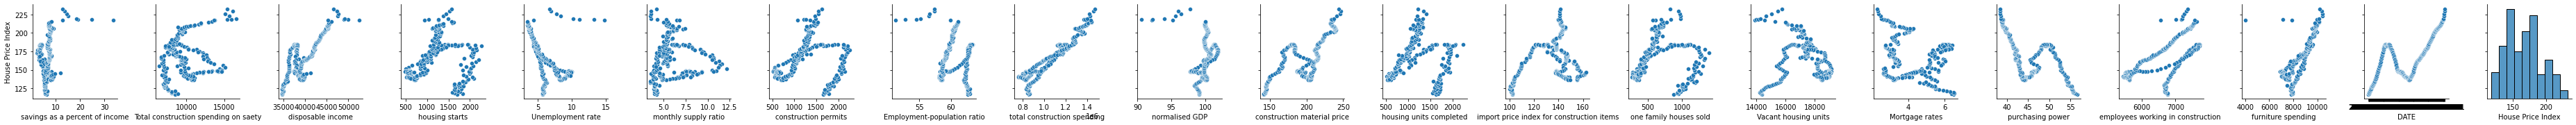

In [240]:
sns.pairplot(data=df , y_vars=['House Price Index'],x_vars=df.columns)

It is observed that some variables has considerable linear relationship , while some like don't.

#Let us take a look at the correlation table

In [ ]:
corr_table = df.corr()['House Price Index']
corr_table

Considering absolute value of over 0.6 to be a good correlation co-efficient, we can see that a few variables exhibit a considerable linear relationship with House Price Index

# Next we would try to fit in various models and pick the best fit

# A **Multiple Polynomial Regression model** can be a good fit. 


In [242]:
df.drop('DATE' , axis=1 ,  inplace=True)

In [243]:
from sklearn.model_selection import train_test_split

In [244]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from sklearn.metrics import r2_score
X = df.drop('House Price Index' ,  axis=1)
y= df['House Price Index']


Trying different Degrees on Polinomial Regression

In [245]:
scores = []
y_pred_list=[]

vals=[1,2,3]
for i in vals:
    poly = PolynomialFeatures(degree=i)
    poly_X= poly.fit_transform(X)
    X_train, X_test, y_train , y_test = train_test_split(poly_X , y, train_size = 0.8, test_size = 0.2, random_state = 100)
    regression = linear_model.LinearRegression()
    model = regression.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_list.append(y_pred)
    score = r2_score(y_test, y_pred)
    scores.append(score)

In [246]:
scores

[0.9796040360013546, 0.830702997294979, 0.5554516857743946]

Even though the Scroe of degree 1 is best, we go with degree 2 as it takes care of non linear relationship and the Residual Sum of Squres wont deviate drastically for the linear curves

# Creating a table to compare with Actual and Predicted value of House Price Index

In [247]:
one = pd.DataFrame(y_pred_list[0])
two = pd.DataFrame(y_pred_list[1])

In [248]:
actual = pd.DataFrame(y_test)

In [249]:
actual.reset_index(level=0 , inplace=True)

In [250]:
comp = actual.join(one)

In [251]:
comp.drop('index' , axis=1 , inplace=True)

In [252]:
comp.rename({0:'Degree One Predicted'} ,  axis='columns' , inplace=True)

In [253]:
comp = pd.concat([comp, two], axis=1, sort=False)

In [254]:
comp.rename({0:'Degree two Predicted'} ,  axis='columns' , inplace=True)

In [ ]:
comp

The above table shows actual vs predicted House Price Index values. As we can see both, degree one and degree two results show low deviations from the mean actual

In [257]:
sum(comp['Degree One Predicted'])/46

170.41118385257545

In [258]:
sum(comp['House Price Index'])/46

169.5613260869565

In [259]:
sum(comp['Degree two Predicted'])/46

171.5989316454648

Their mean Value are very close to each other

# Trying to fit another model - Random Forest

In [260]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=100)

In [261]:
from sklearn.ensemble import RandomForestRegressor

In [262]:
rf = RandomForestRegressor(n_estimators=10 , random_state=42)

In [263]:
rf.fit(X_train , y_train)

RandomForestRegressor(n_estimators=10, random_state=42)

In [264]:
y_pred = rf.predict(X_test)

In [265]:
score = r2_score(y_test, y_pred)
score

0.99649577447323

# 11 trees are hard to visualise. Let us reset the depth

In [266]:
rf.estimators_[5].tree_.max_depth

11

# This is one of the 100 trees. It is to be noted that all 100 trees(models) are making predictions and this is only one such model

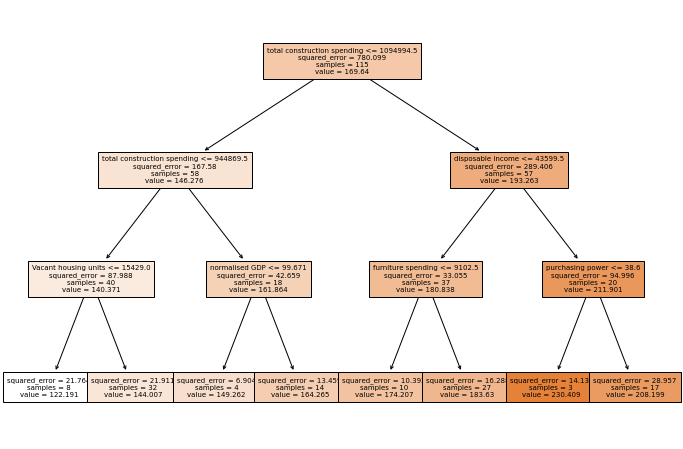

In [267]:
from sklearn import tree
rf = RandomForestRegressor(n_estimators=100, max_depth=3)
rf.fit(X_train, y_train)
_ = tree.plot_tree(rf.estimators_[0], feature_names=X_train.columns, filled=True , fontsize=7)

In [268]:
y_pred = rf.predict(X_test)
score = r2_score(y_test, y_pred)
score

0.974564882712393

We got an excellent R2 Score.

# Preforming Cross Validation

In [ ]:
from sklearn.model_selection import GridSearchCV
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
params = {'max_depth': [2,3,5,10,20],'min_samples_leaf': [5,10,20,50,100,200],'n_estimators': [10, 25, 50, 100 , 500]}
grid_search = GridSearchCV(estimator=rf,param_grid=params,cv = 4,n_jobs=-1, verbose=1, scoring="r2")
grid_search.fit(X_train, y_train)

In [273]:
grid_search.best_score_

0.9839477618700648

In [274]:
dt_best = grid_search.best_estimator_
dt_best

RandomForestRegressor(max_depth=10, min_samples_leaf=5, n_estimators=50,
                      n_jobs=-1, random_state=42)

In [275]:
rf = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_samples_leaf=5,min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)
rf.fit(X_train , y_train)
y_pred = rf.predict(X_test)
score = r2_score(y_test, y_pred)
score

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


0.9910490068814858

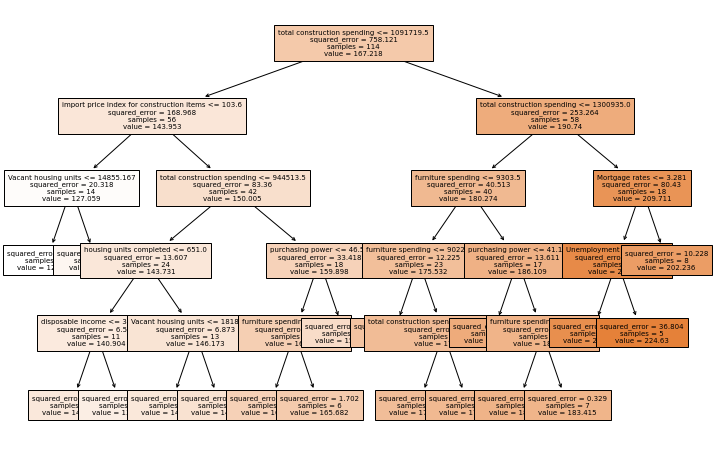

In [276]:
_ = tree.plot_tree(rf.estimators_[49], feature_names=X_train.columns, filled=True , fontsize=7)

**We obtain an r2 score of 99.1% which is excellent for a model.**

So we can conclude that instead of fitting lines on the plots of the data, taking a conidtion based evaluation approach would give better results, especially for higher values of HPI

In [ ]:
y_pred

In [278]:
random_forest = pd.DataFrame(y_pred)

In [279]:
random_forest.rename({0:'Random Forest Predicted'} , axis=1 , inplace=True)

In [280]:
comp = comp.join(random_forest)

In [281]:
try:
    comp.drop('Random Forest Prediction' , axis=1,inplace=True)
except:
    comp=comp

In [282]:
comp = comp.sort_values(by='House Price Index', ascending=False)

**Below tables are for observation:**

In [ ]:
comp

In [287]:
comp['Degree one deviation'] = abs(comp['House Price Index']-comp['Degree One Predicted'])
comp['Degree two deviation'] = abs(comp['House Price Index']-comp['Degree two Predicted'])
comp['Random Forest deviation'] = abs(comp['House Price Index']-comp['Random Forest Predicted'])

In [ ]:
comp

On close observation of the values, we can see that Random Forest predictions are the closest to near values. However, it is to be noted for mid-values (150-170) , polynomial regression has performed slightly better


**Since we have achieved an R2 score of 99%, we need not fit in an XGBoost Regressor**

# Part 2: Time Series Analysis

**Preparing the data for visualisation**

In [289]:
l=[]
c= wex_input_folder("/content/Housing ML")
for i in c:
    l.append(pd.read_csv(i))
for o in l:
    o.drop(['DATE'] , axis=1 , inplace=True)
df =  l[0]
u=1
while u<len(l):
    df2 = df.join(l[u])
    df=df2
    u+=1
df = df.join(pd.read_csv("/content/HPI.csv"))
df.rename({"CSUSHPISA":"House Price Index"} , axis='columns' , inplace=True)

In [290]:
time_Series_df = df[['DATE' , 'House Price Index']]

In [ ]:
time_Series_df['DATE'] = pd.to_datetime(time_Series_df['DATE'])

In [ ]:
time_Series_df

In [ ]:
time_Series_df.info()

**Ploting the data**

In [ ]:
time_Series_df.plot(x='DATE' , figsize=(20, 8))
plt.show()

**Let us look at the decomposition**

In [297]:
from pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

In [298]:
rcParams['figure.figsize'] = 12, 8

In [ ]:
time_Series_df['House Price Index'].interpolate(inplace = True)

In [ ]:
time_Series_df['DATE'] = pd.to_datetime(time_Series_df['DATE'])
time_Series_df = time_Series_df.set_index('DATE')
time_Series_df = time_Series_df.fillna(method='bfill').fillna(method='ffill')

In [301]:
decomposition = seasonal_decompose(time_Series_df)#['House Price Index'])

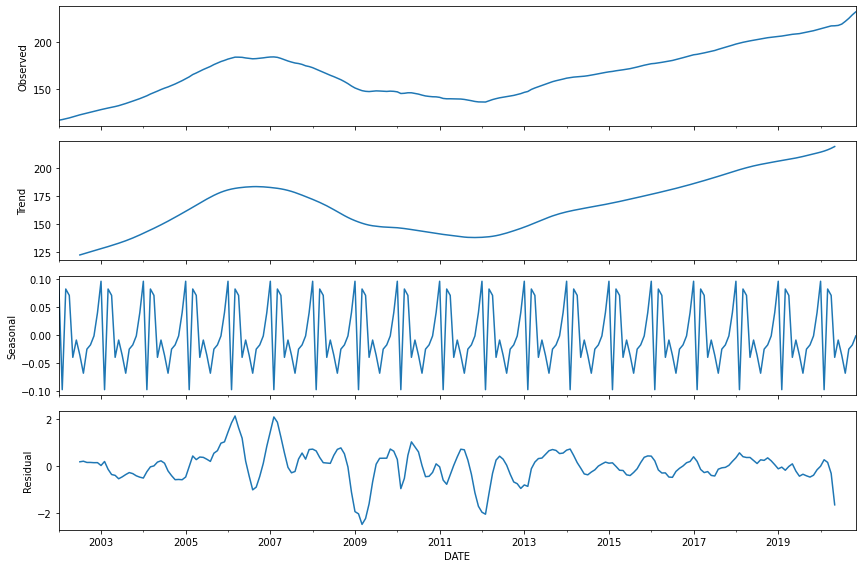

In [302]:
fig = decomposition.plot()
plt.show()

We can observe that there is some seasonality when the data is divided into eights. 

The trend is upward as expected. 

Since the trend is evident,let us take a look at how Holt's exponential smoothing performs on this data

# Performing Holt's exponential smoothing on data

In [303]:
train_len = 180
train = time_Series_df[0:train_len] # first 180 months as training set
test = time_Series_df[train_len:] # last 47 months as out-of-time test set

In [304]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
model = ExponentialSmoothing(np.asarray(train['House Price Index']) ,seasonal_periods=12 ,trend='additive', seasonal=None)
model_fit = model.fit(smoothing_level=0.2, smoothing_slope=0.01, optimized=False)
print(model_fit.params)
y_hat_holt = test.copy()
y_hat_holt['holt_forecast'] = model_fit.forecast(len(test))

{'smoothing_level': 0.2, 'smoothing_slope': 0.01, 'smoothing_seasonal': None, 'damping_slope': nan, 'initial_level': 117.143, 'initial_slope': 0.7019999999999982, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


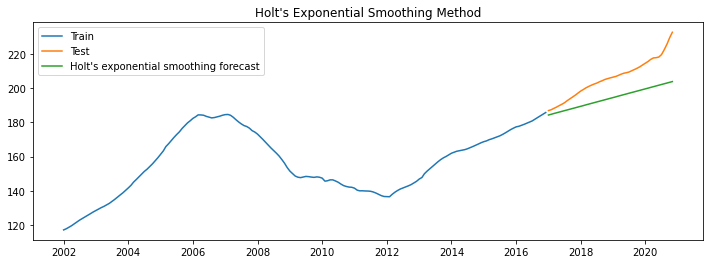

In [305]:
plt.figure(figsize=(12,4))
plt.plot( train['House Price Index'], label='Train')
plt.plot(test['House Price Index'], label='Test')
plt.plot(y_hat_holt['holt_forecast'], label='Holt\'s exponential smoothing forecast')
plt.legend(loc='best')
plt.title('Holt\'s Exponential Smoothing Method')
plt.show()

**We can observe that the green line(fitted line) is well below the actual continuation of the curve(orange curve).**

In [306]:
mape = np.round(np.mean(np.abs(test['House Price Index']-y_hat_holt['holt_forecast'])/test['House Price Index'])*100,2)
mape

5.58

In [307]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test['House Price Index'], y_hat_holt['holt_forecast'])).round(2)
rmse

13.03

**Though MAPE seems to be low, A root mean squared error of 13.03 is pretty high. 

Let us see if we can obtain improved results using Holt-Winter's exponential smoothing**

# Performing Holt-Winter's exponential smoothing

In [308]:
y_hat_hwa = test.copy()
model = ExponentialSmoothing(np.asarray(train['House Price Index']) ,seasonal_periods=8 ,trend='add', seasonal='add')
model_fit = model.fit(optimized=True)
print(model_fit.params)
y_hat_hwa['hw_forecast'] = model_fit.forecast(len(test))

{'smoothing_level': 0.6315789447068929, 'smoothing_slope': 0.13928169392944872, 'smoothing_seasonal': 0.3684210499700508, 'damping_slope': nan, 'initial_level': 154.37642342240844, 'initial_slope': 0.8422153658521888, 'initial_seasons': array([-36.16677939, -35.75165619, -35.71691745, -35.97009224,
       -36.18204266, -36.24640128, -35.9557653 , -35.23024206]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


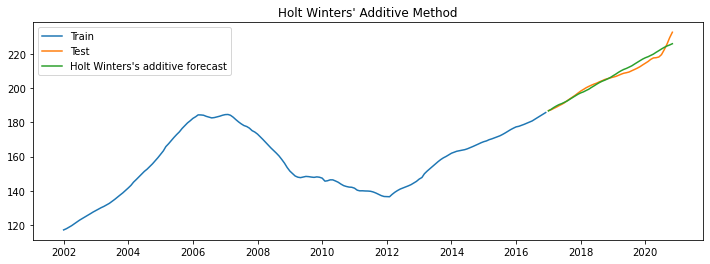

In [309]:
plt.figure(figsize=(12,4))
plt.plot( train['House Price Index'], label='Train')
plt.plot(test['House Price Index'], label='Test')
plt.plot(y_hat_hwa['hw_forecast'], label='Holt Winters\'s additive forecast')
plt.legend(loc='best')
plt.title('Holt Winters\' Additive Method')
plt.show()

**Now we can observe that the green line sits almost perfectly on the orange part of the curve.**

In [311]:
rmse = np.sqrt(mean_squared_error(test['House Price Index'], y_hat_hwa['hw_forecast'])).round(2)
rmse

2.19

In [312]:
mape = np.round(np.mean(np.abs(test['House Price Index']-y_hat_hwa['hw_forecast'])/test['House Price Index'])*100,2)
mape

0.79

**Result has been improved.**

# Checking if the multiplicative method would yield better results

In [313]:
y_hat_hwm = test.copy()
model = ExponentialSmoothing(np.asarray(train['House Price Index']) ,seasonal_periods=6,trend='add', seasonal='mul')
model_fit = model.fit(optimized=True)
print(model_fit.params)
y_hat_hwm['hw_forecast'] = model_fit.forecast(len(test))

{'smoothing_level': 0.6315789471221258, 'smoothing_slope': 0.21052992726713532, 'smoothing_seasonal': 0.3684210523852837, 'damping_slope': nan, 'initial_level': 155.8310932746789, 'initial_slope': 0.9914676866944975, 'initial_seasons': array([0.76456429, 0.76665184, 0.76487724, 0.76177714, 0.76171386,
       0.76663019]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


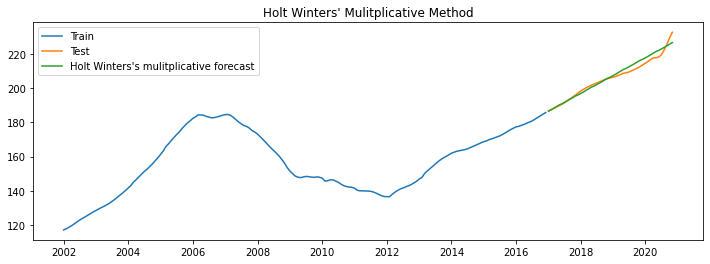

In [314]:
plt.figure(figsize=(12,4))
plt.plot( train['House Price Index'], label='Train')
plt.plot(test['House Price Index'], label='Test')
plt.plot(y_hat_hwm['hw_forecast'], label='Holt Winters\'s mulitplicative forecast')
plt.legend(loc='best')
plt.title('Holt Winters\' Mulitplicative Method')
plt.show()

In [315]:
rmse = np.sqrt(mean_squared_error(test['House Price Index'], y_hat_hwm['hw_forecast'])).round(2)
rmse

2.23

In [316]:
mape = np.round(np.mean(np.abs(test['House Price Index']-y_hat_hwm['hw_forecast'])/test['House Price Index'])*100,2)
mape

0.81

**Multiplicative and additive methods exhibit similar performances**

**An error of 0.81% (2.23 Index points) is a low one. Auto-Regressive models are not required since we have obtained good accuracy**

# Creating a dataframe so we can predict HPI for 2022

In [ ]:
df_add= pd.DataFrame([['2020-12-01', 0], ['2021-01-01', 0] ,['2021-02-01', 0], ['2021-03-01', 0] , ['2021-04-01', 0] , ['2021-05-01', 0] , ['2021-06-01', 0], ['2021-07-01', 0], ['2021-08-01', 0], ['2021-09-01', 0], ['2021-10-01', 0], ['2021-11-01', 0] ,['2021-12-01', 0], ['2022-01-01', 0] , ['2022-02-01', 0], ['2022-03-01', 0], ['2022-04-01', 0], ['2022-05-01', 0] , ['2022-06-01', 0], ['2022-07-01', 0] ], columns=['DATE' , 'House Price Index'])
df_add

In [318]:
df_add['DATE'] = pd.to_datetime(df_add['DATE'])

In [319]:
df_try = test.append(df_add)

In [320]:
df_try.index = (list(range(180,247,1)))

In [321]:
pred = model_fit.predict(start=df_try.index[0], end=df_try.index[-1])

In [323]:
new = pd.DataFrame([['Jan 2022' , 238.54912983 ] , ['Feb 2022' , 239.41644337 ], ['March 2022' , 240.35418086 ], ['April 2022' , 241.31442187 ], ['May 2022' , 242.2695893], ['Jun 2022' , 242.92041184 ] , ['Jul 2022' ,243.75648779 ]] , columns=['Month' , 'Predicted House Price Index'])
new


,Month,Predicted House Price Index
0,Jan 2022,238.549130
1,Feb 2022,239.416443
2,March 2022,240.354181
3,April 2022,241.314422
4,May 2022,242.269589
5,Jun 2022,242.920412
6,Jul 2022,243.756488


In [324]:
new['Predicted House Price index lower range'] = 0.9919*(new['Predicted House Price Index'])
new['Predicted House Price index higher range'] = 1.0081*(new['Predicted House Price Index'])

In [325]:
new.drop('Predicted House Price Index' , axis=1 , inplace=True)
new

,Month,Predicted House Price index lower range,Predicted House Price index higher range
0,Jan 2022,236.616882,240.481378
1,Feb 2022,237.477170,241.355717
2,March 2022,238.407312,242.301050
3,April 2022,239.359775,243.269069
4,May 2022,240.307206,244.231973
5,Jun 2022,240.952757,244.888067
6,Jul 2022,241.782060,245.730915


**The above table shows the higher and lower ranges for predicted HPI for the first 7 months of 2022**

# Conclusions

1. The factors that play a crucial role in the determination of HPI are Spending on Construction, Disposable income,number of construction employees, and spending on furniture. Other considerable factors include Purchasing Power and Unemployment rate.

2. When making decisions, close attention must be paid to previous years' data since the percentage growth/fall of values of certain features can speak volumes about the future.

3. Surprisingly, data points of housing starts and monthly supply ratio were fairly random.

4. Polynomial regression with a degree of two showed good accuracy. If one chooses to go for polynomial regression, a degree of two is recommended.

5. The Random Forest Regressor performed exceedingly better than the other forms of regression, thanks to it's condition evaluation based approach.

4. Time series analysis showed that the graph of HPI generally follows an upward trend with 'Black-Swan' situations being execeptions (2006-2012). The fall in HPI north of 2006 being due to the Real Estate Market crash and that post 2010 being due to the Dot-com bubble.

5. The graph of HPI exhibits considerable seasonality when divided into eights.

6. Holt-Winter's Exponential Smoothing (Additive and Multiplicative) has yielded an excellent accuracy with an error of only 0.81%. This has allowed us to perdict the HPI for the first few months of January. It is to be noted that the higher range of HPI might be slightly higher, with the Housing Market catching up pretty quick, especially after the vaccine release.

7. The question that remains is wether we should go with time series or regression for making predictions. The answer - situational. During bubbles or crises, make predictions based on the all available data for that period (regression). In case of normal and smooth course of events, go for time series forecasting.